In [475]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
from matplotlib import cm

In [476]:
import numpy as np
import pandas as pd

In [477]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [478]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [479]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [481]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [482]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [483]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [484]:
# Create our session (link) from Python to the DB
session = Session(engine)

inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])  

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [485]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])  

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [486]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date=session.query(func.max(Measurement.date)).first()
print(f"The last date entry in the data table {last_date[0]}")

query_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d') - dt.timedelta(days=365)

# Calculate the date 1 year ago from the last data point in the database
stmt=(session
 .query(Measurement.date, Measurement.prcp)
 .filter(Measurement.date > query_date)
 .statement)

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df_one_year = pd.read_sql(stmt, engine).set_index('date').sort_values('date',ascending=True)
df_one_year.head(10)

The last date entry in the data table 2017-08-23


,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
2016-08-24,1.22
2016-08-25,0.08
2016-08-25,0.00


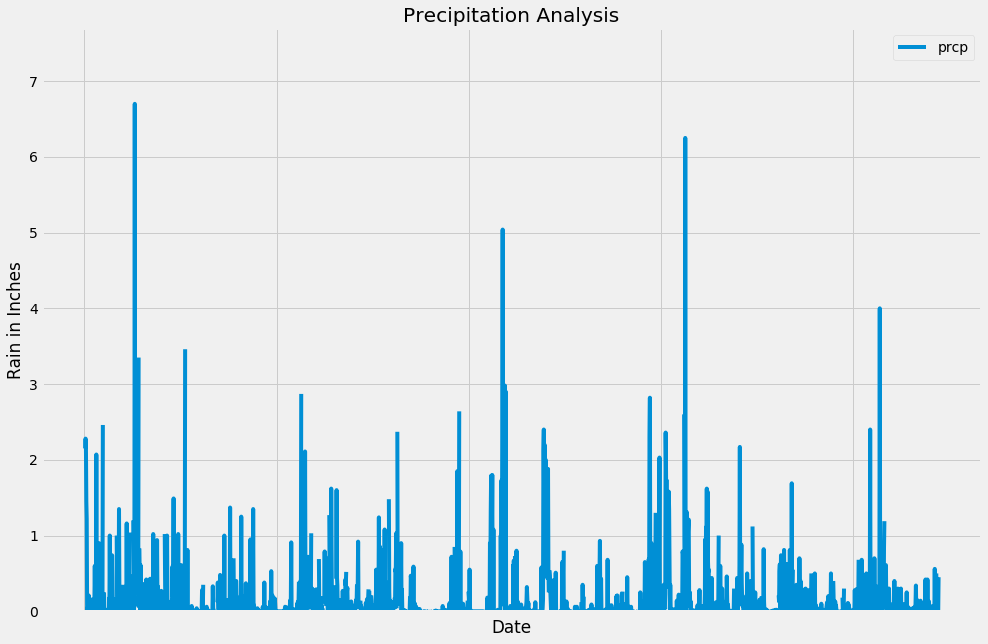

In [515]:
# Use Pandas Plotting with Matplotlib to plot the data
df_one_year.plot(kind="line",linewidth=4,figsize=(15,10))
ax.set_xticklabels([])
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.ylim(0,df_one_year['prcp'].max()+1)
plt.title("Precipitation Analysis")
plt.legend(loc="best")
# Save Figure
plt.savefig("output/Precipitation Analysis.png",dpi=300, bbox_inches = "tight")
plt.show()

In [488]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_one_year.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [489]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations in Station table.".format(locations))

There are 9 stations in Station table.


In [490]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
(session.query(Measurement.station,func.count(Measurement.station)) 
 .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all())

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [491]:
most_active_station=session.query(Measurement.station)\
.group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]
print(f"The busiest Station was {most_active_station}")  

# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

stats=(session
 .query(*sel)          
 .filter(Measurement.station==most_active_station)
 .all())

print(stats)

The busiest Station was USC00519281
[(54.0, 85.0, 71.66378066378067)]


In [492]:
# Choose the station with the highest number of temperature observations.
highest_number_of_temperature=session.query(Measurement.station,func.max(Measurement.tobs))\
.order_by(func.count(Measurement.station).desc()).first()

print(f"The highest number of temperature belongs to {highest_number_of_temperature[0]}, {highest_number_of_temperature[1]}")

The highest number of temperature belongs to USC00519397, 87.0


In [493]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date_station=session.query(func.max(Measurement.date))\
        .filter(Measurement.station==highest_number_of_temperature[0]).first()[0]
    
query_date_station = dt.datetime.strptime(last_date_station, '%Y-%m-%d') - dt.timedelta(days=365)

stmt=(session
 .query(Measurement.date, Measurement.tobs)
 .filter(Measurement.date >= query_date_station, Measurement.station==highest_number_of_temperature[0])
 .statement)

df_one_year_temperature = pd.read_sql(stmt, engine).set_index('date').sort_values('date',ascending=False)
df_one_year_temperature.head(10)

,tobs
date,
2017-08-23,81.0
2017-08-22,82.0
2017-08-21,81.0
2017-08-20,81.0
2017-08-19,79.0
2017-08-18,80.0
2017-08-15,78.0
2017-08-14,79.0
2017-08-13,81.0


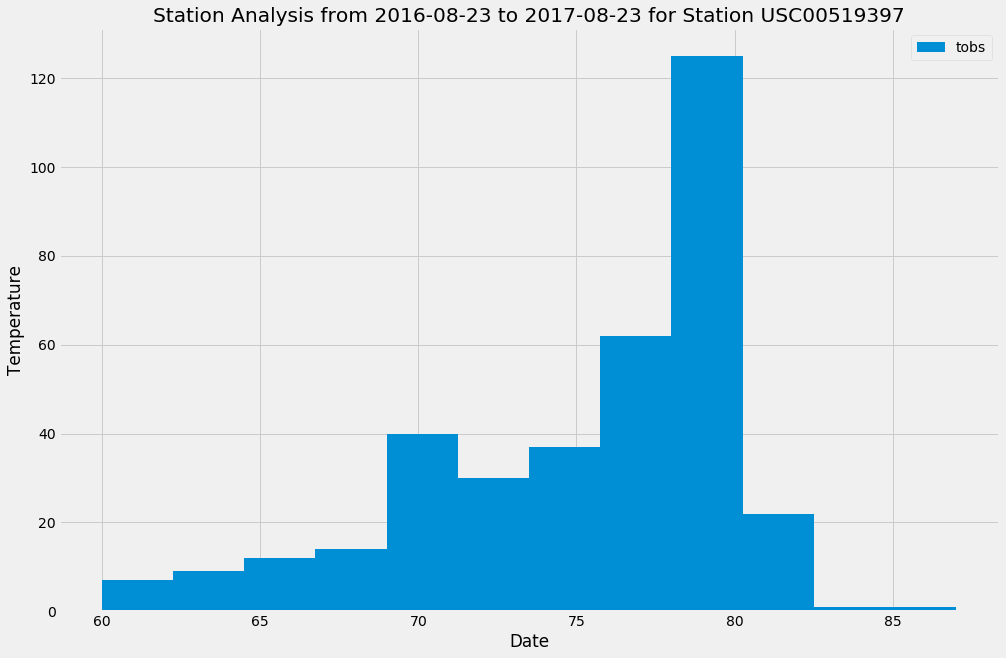

In [517]:
df_one_year_temperature.plot(kind="hist",bins=12,linewidth=4,figsize=(15,10))
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend(loc="best")
title=f"Station Analysis from {query_date_station.strftime('%Y-%m-%d')} to {last_date_station} for Station {highest_number_of_temperature[0]}"
plt.title(title)
plt.savefig(f"output/{title}.png",dpi=300, bbox_inches = "tight")
plt.show()

In [495]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [496]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date="2017-01-01"
vacation_range=7
trip_end_date=(dt.datetime.strptime(trip_start_date, '%Y-%m-%d') + dt.timedelta(days=vacation_range)).strftime('%Y-%m-%d')
print(f"Trip StartDate {trip_start_date}, EndDate {trip_end_date}")
myTrip=calc_temps(trip_start_date,trip_end_date)
print(myTrip)

Trip StartDate 2017-01-01, EndDate 2017-01-08
[(60.0, 68.27659574468085, 74.0)]


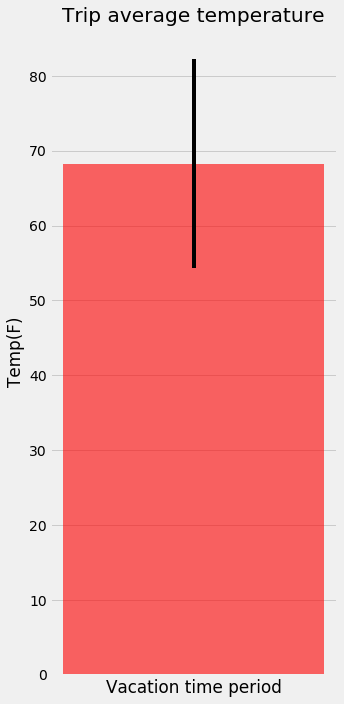

In [518]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerror=myTrip[0][2]-myTrip[0][0]
barvalue = [myTrip[0][1]]#avg
xvals = range(len(barvalue))

fig,ax = plt.subplots(figsize=(5,10))
ax.bar(xvals, barvalue, yerr=yerror, color='r',alpha=0.6)
ax.set_xticks([1]) 
plt.xlabel("Vacation time period")
plt.ylabel("Temp(F)")
plt.title("Trip average temperature")
plt.tight_layout()
# Save Figure
plt.savefig("output/Trip average temperature.png",dpi=300, bbox_inches = "tight")
plt.show()

In [511]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date="01-01"
vacation_range=7
end_date=(dt.datetime.strptime(start_date, '%m-%d') + dt.timedelta(days=vacation_range)).strftime('%m-%d')

sel=[Measurement.station,
     Station.name,
     func.sum(Measurement.prcp).label("sumPrcp"),
     Station.latitude,
     Station.longitude,
     Station.elevation
]
result=(session.query(*sel)
        .group_by(Measurement.station)
        .filter(Measurement.station==Station.station)
        .filter(func.strftime("%m-%d", Measurement.date) >= start_date, func.strftime("%m-%d", Measurement.date) <= end_date)
        .order_by(func.sum(Measurement.prcp).desc())
        .all())


for r in result:
    print(f"station: {r.station} name: {r.name} rain amount: {r.sumPrcp} latitude: {r.latitude} longitude: {r.longitude} elevation: {r.elevation}")

station: USC00516128 name: MANOA LYON ARBO 785.2, HI US rain amount: 23.359999999999996 latitude: 21.3331 longitude: -157.8025 elevation: 152.4
station: USC00519281 name: WAIHEE 837.5, HI US rain amount: 8.079999999999997 latitude: 21.45167 longitude: -157.84888999999998 elevation: 32.9
station: USC00513117 name: KANEOHE 838.1, HI US rain amount: 6.739999999999998 latitude: 21.4234 longitude: -157.8015 elevation: 14.6
station: USC00519523 name: WAIMANALO EXPERIMENTAL FARM, HI US rain amount: 5.909999999999998 latitude: 21.33556 longitude: -157.71139 elevation: 19.5
station: USC00514830 name: KUALOA RANCH HEADQUARTERS 886.9, HI US rain amount: 2.8599999999999994 latitude: 21.5213 longitude: -157.8374 elevation: 7.0
station: USC00519397 name: WAIKIKI 717.2, HI US rain amount: 2.5700000000000003 latitude: 21.2716 longitude: -157.8168 elevation: 3.0
station: USC00511918 name: HONOLULU OBSERVATORY 702.2, HI US rain amount: 2.44 latitude: 21.3152 longitude: -157.9992 elevation: 0.9
station: 

## Optional Challenge Assignment

In [498]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [499]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
trip=["01-01","01-02","01-03","01-04","01-05","01-06","01-07"]
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
normals=map(daily_normals,trip)
normals
z=dict(zip([f"2018-{d}" for d in trip],[x[0] for x in normals]))
z

{'2018-01-01': (62.0, 69.15384615384616, 77.0),
 '2018-01-02': (60.0, 69.39622641509433, 77.0),
 '2018-01-03': (62.0, 68.9090909090909, 77.0),
 '2018-01-04': (58.0, 70.0, 76.0),
 '2018-01-05': (56.0, 67.96428571428571, 76.0),
 '2018-01-06': (61.0, 68.96491228070175, 76.0),
 '2018-01-07': (57.0, 68.54385964912281, 76.0)}

In [500]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_trip = pd.DataFrame.from_dict(z, orient='index',
                     columns=['tmin', 'tavg', 'tmax'])
df_trip

,tmin,tavg,tmax
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


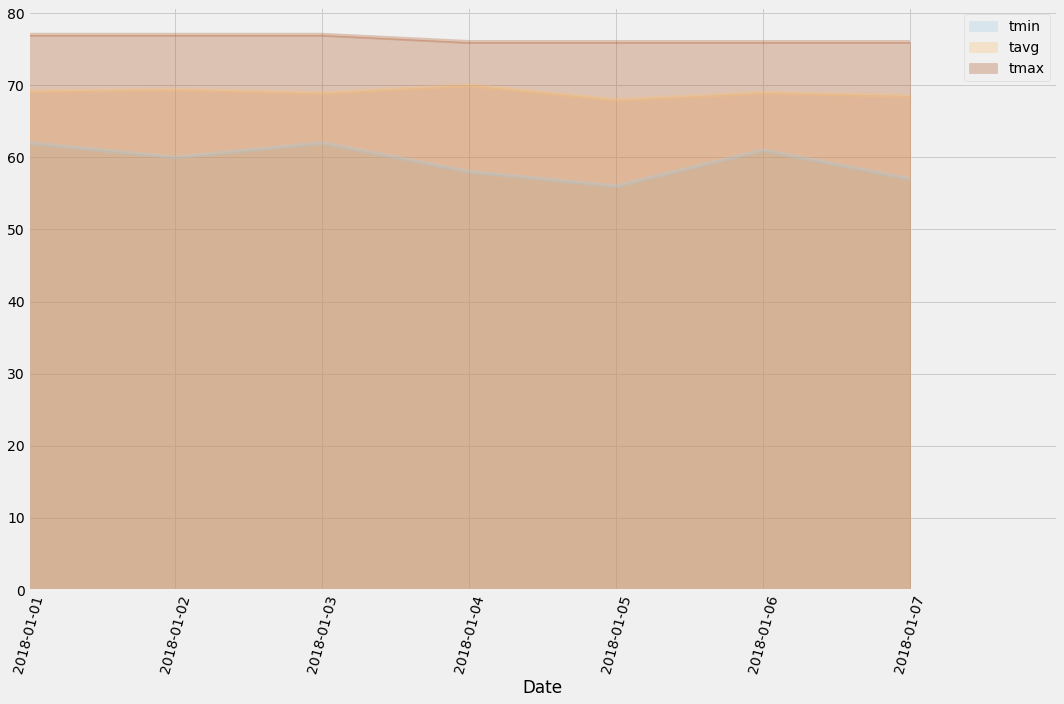

In [474]:
# Plot the daily normals as an area plot with `stacked=False`
ax=df_trip.plot(kind='area', stacked=False,figsize=(15,10), alpha=0.3,
        title='',cmap = cm.get_cmap('Paired'))
ax.set_xticklabels(df_trip.index, rotation=75)
plt.xlim(0,7)
plt.xlabel("Date")
plt.tight_layout()

# Save Figure
plt.savefig("output/Trip average temperature.png",dpi=300, bbox_inches = "tight")
plt.show()